Operating in FLE Standard Time time.
Current time is 2021-02-09 00:05:22.705290+02:00:
Download range: from 4.324064 to 96.111792 Mbps
Upload range: from 6.8506 to 112.591992 Mbps



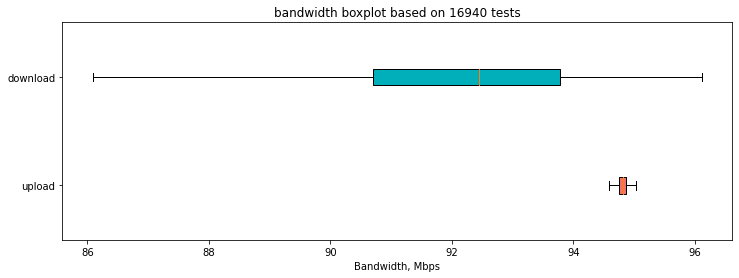

In [51]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from dateutil.tz import *

%matplotlib inline

with open(".\internetspeed.json") as f:
  data = json.load(f)

df = pd.json_normalize(data)

#timestamp is in UTC timezone
df.index=pd.to_datetime(df['timestamp'])
print("Operating in {curent_tzone} time.".format(curent_tzone=datetime.now(tzlocal()).tzname()))
print("Current time is {curent_time}:".format(curent_time=datetime.now(tzlocal())))

#making index timezone-specific
df.tz_convert(tzlocal())
df.head()

print("Download range: from {dmin} to {dmax} Mbps".format(dmin = df['download.bandwidth'].min()*8/1000000, dmax = df['download.bandwidth'].max()*8/1000000))
print("Upload range: from {umin} to {umax} Mbps".format(umin = df['upload.bandwidth'].min()*8/1000000, umax = df['upload.bandwidth'].max()*8/1000000))
print("")

data = [df['upload.bandwidth']*8/1000000, df['download.bandwidth']*8/1000000]
labels = ['upload', 'download']

# rectangular box plot

plt.figure(figsize=(12,4))
plt.title("bandwidth boxplot based on {tests} tests".format(tests = len(df)))
plt.xlabel('Bandwidth, Mbps')

bplot = plt.boxplot(
  data,
  vert=False,  # horizontal box alignment
  patch_artist=True,  # fill with color
  labels=labels,
  showfliers=False
) 
colors = ["#F07167", "#00AFB9"]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)



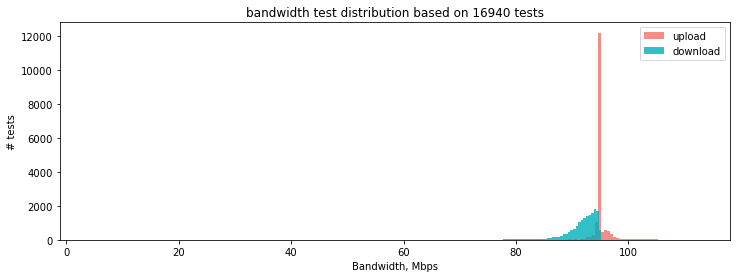

In [52]:
num_bins = 200
plt.figure(figsize=(12,4))
plt.hist(df['upload.bandwidth']*8/1000000, num_bins, facecolor=colors[0], alpha=0.8,label='upload')
plt.hist(df['download.bandwidth']*8/1000000, num_bins, facecolor=colors[1], alpha=0.8,label='download')
plt.title("bandwidth test distribution based on {tests} tests".format(tests = len(df)))
plt.xlabel('Bandwidth, Mbps')
plt.ylabel('# tests')
plt.legend()
plt.show()


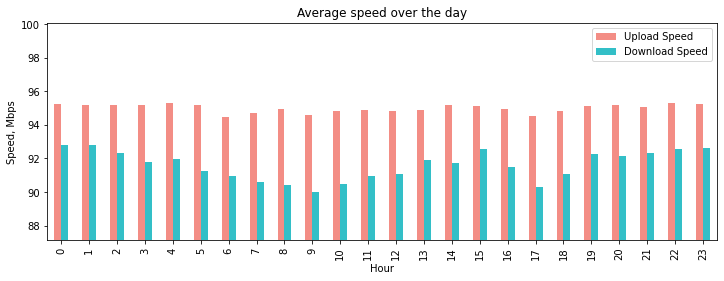

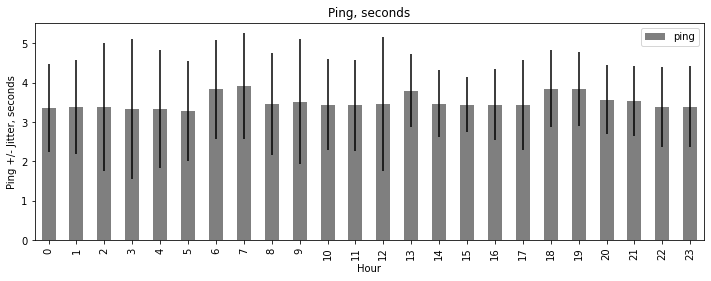

In [58]:
plotting = pd.DataFrame()
plotting['Download Speed'] =  df.groupby(df.index.hour)['download.bandwidth'].agg('mean')*8/1000000
plotting['Upload Speed'] = df.groupby(df.index.hour)['upload.bandwidth'].agg('mean')*8/1000000
plotting['dstd'] = df.groupby(df.index.hour)['download.bandwidth'].agg('std')*8/1000000
plotting['ustd'] = df.groupby(df.index.hour)['upload.bandwidth'].agg('std')*8/1000000
plotting['ping'] = df.groupby(df.index.hour)['ping.latency'].agg('mean')
plotting['jitter'] =  df.groupby(df.index.hour)['ping.jitter'].agg('mean')

#calculate lower bound for a better visualization
ylim_min = min([plotting['Download Speed'].min(), plotting['Upload Speed'].min()]) - (df.groupby(df.index.hour)['download.bandwidth'].agg('std')*8/1000000+df.groupby(df.index.hour)['upload.bandwidth'].agg('std')*8/1000000).mean()/2

plotting.head()

import numpy as np

plotting.plot(
    y=['Upload Speed', 'Download Speed'], 
    kind="bar", 
    alpha=0.8, 
    color=colors,
    xticks=np.arange(24), 
    title="Average speed over the day",
    ylabel="Speed, Mbps", 
    xlabel="Hour", 
    figsize=(12,4), 
    ylim=ylim_min, 
    #yerr=[plotting['ustd'], plotting['dstd']]
)

plotting.plot(
    y=['ping'], 
    kind="bar", 
    yerr="jitter", 
    alpha=0.5, 
    color=["black"],
    xticks=np.arange(24), 
    title="Ping, seconds",
    ylabel="Ping +/- Jitter, seconds", 
    xlabel='Hour', 
    figsize=(12,4)
)

plt.show()